### Multiclass classification models using neural networks
Data:<br>https://www.kaggle.com/competitions/Kannada-MNIST

### Autoencoder + classifier 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

random_state = 42
tf.random.set_seed(random_state)
np.random.seed(random_state)

In [2]:
# load data
train = pd.read_csv('drive/MyDrive/input/Kannada-MNIST/train.csv')
test = pd.read_csv('drive/MyDrive/input/Kannada-MNIST/test.csv', index_col='id')
sample_submission = pd.read_csv('drive/MyDrive/input/Kannada-MNIST/sample_submission.csv')

# define X_train, y_train, and X_test
X_train = train.drop('label', axis=1)
y_train = train['label']
X_test = test

# normalize data from 0 to 1
X_train = X_train.astype(float)/255.
X_test = X_test.astype(float)/255.

# reshape data
X_train = X_train.to_numpy().reshape(-1, 28, 28, 1)
X_test = X_test.to_numpy().reshape(-1, 28, 28, 1)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}\nX_test: {X_test.shape}')

X_train: (60000, 28, 28, 1), y_train: (60000, 10)
X_test: (5000, 28, 28, 1)


In [3]:
# train val split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}\nX_val: {X_val.shape}, y_val: {y_val.shape}')

X_train: (48000, 28, 28, 1), y_train: (48000, 10)
X_val: (12000, 28, 28, 1), y_val: (12000, 10)


In [4]:
# autoencoder: encoder
input_img = tf.keras.layers.Input(shape=(28, 28, 1))
ee = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(input_img)
ee = tf.keras.layers.BatchNormalization()(ee)
ee = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(ee)
ee = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(ee)
ee = tf.keras.layers.BatchNormalization()(ee)
ee = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(ee)
ee = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(ee)
ee = tf.keras.layers.BatchNormalization()(ee)
ee = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(ee)
ee = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(ee)
ee = tf.keras.layers.BatchNormalization()(ee)
ee = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(ee)
encoder = tf.keras.models.Model(inputs=input_img, outputs=ee, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 256)       2560      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 256)       1024      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       295040    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0   

In [5]:
# autoencoder: decoder
encoder_output = tf.keras.layers.Input(shape=list(encoder.output.shape)[1:])
dd = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(encoder_output)
dd = tf.keras.layers.UpSampling2D((2, 2))(dd)
dd = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(dd)
dd = tf.keras.layers.UpSampling2D((2, 2))(dd)
dd = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(dd)
dd = tf.keras.layers.UpSampling2D((2, 2))(dd)
dd = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(dd)
dd = tf.keras.layers.UpSampling2D((2, 2))(dd)
dd = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(dd)
decoder = tf.keras.models.Model(inputs=encoder_output, outputs=dd, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2, 2, 32)]        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 32)          9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 16, 16, 128)       0   

In [6]:
# construct autoencoder
ae = tf.keras.models.Model(inputs=input_img, outputs=decoder(encoder(input_img)), name='ae')
ae.summary()

Model: "ae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 2, 2, 32)          391776    
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         399073    
Total params: 790,849
Trainable params: 789,889
Non-trainable params: 960
_________________________________________________________________


In [7]:
# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20, verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                                 patience=5, verbose=1, min_lr=1e-7)

checkpoint = tf.keras.callbacks.ModelCheckpoint('ae.h5', monitor='val_loss', verbose=1, 
                                                save_best_only=True, save_weights_only=True)

# compile and fit
ae.compile(optimizer='adam', loss='binary_crossentropy', metrics=None)

ae.fit(x=X_train, y=X_train, batch_size=None, epochs=200,
       callbacks = [es, reduce_lr, checkpoint], 
       validation_data=(X_val, X_val), verbose=2);

Epoch 1/200
1500/1500 - 14s - loss: 0.1139 - val_loss: 0.0946

Epoch 00001: val_loss improved from inf to 0.09462, saving model to ae.h5
Epoch 2/200
1500/1500 - 12s - loss: 0.0909 - val_loss: 0.0890

Epoch 00002: val_loss improved from 0.09462 to 0.08898, saving model to ae.h5
Epoch 3/200
1500/1500 - 11s - loss: 0.0849 - val_loss: 0.0835

Epoch 00003: val_loss improved from 0.08898 to 0.08347, saving model to ae.h5
Epoch 4/200
1500/1500 - 11s - loss: 0.0818 - val_loss: 0.0803

Epoch 00004: val_loss improved from 0.08347 to 0.08035, saving model to ae.h5
Epoch 5/200
1500/1500 - 11s - loss: 0.0794 - val_loss: 0.0786

Epoch 00005: val_loss improved from 0.08035 to 0.07860, saving model to ae.h5
Epoch 6/200
1500/1500 - 11s - loss: 0.0778 - val_loss: 0.0785

Epoch 00006: val_loss improved from 0.07860 to 0.07853, saving model to ae.h5
Epoch 7/200
1500/1500 - 11s - loss: 0.0764 - val_loss: 0.0771

Epoch 00007: val_loss improved from 0.07853 to 0.07714, saving model to ae.h5
Epoch 8/200
1500/

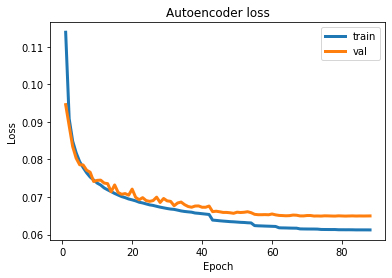

In [8]:
# plot training history
df_plot = pd.DataFrame(ae.history.history)
fig, ax = plt.subplots()
ax.plot(df_plot.index+1, df_plot['loss'], lw=3, label='train')
ax.plot(df_plot.index+1, df_plot['val_loss'], lw=3, label='val')
ax.set(xlabel='Epoch', ylabel='Loss', title='Autoencoder loss')
ax.legend()
plt.show()
fig.savefig('ae_hist.pdf', format='pdf', bbox_inches='tight')

In [9]:
# reload best weights and evaluate model
ae.load_weights('ae.h5')
ae.evaluate(X_test, X_test)

157/157 [==============================] - 1s 6ms/step - loss: 0.0662


0.06618504226207733

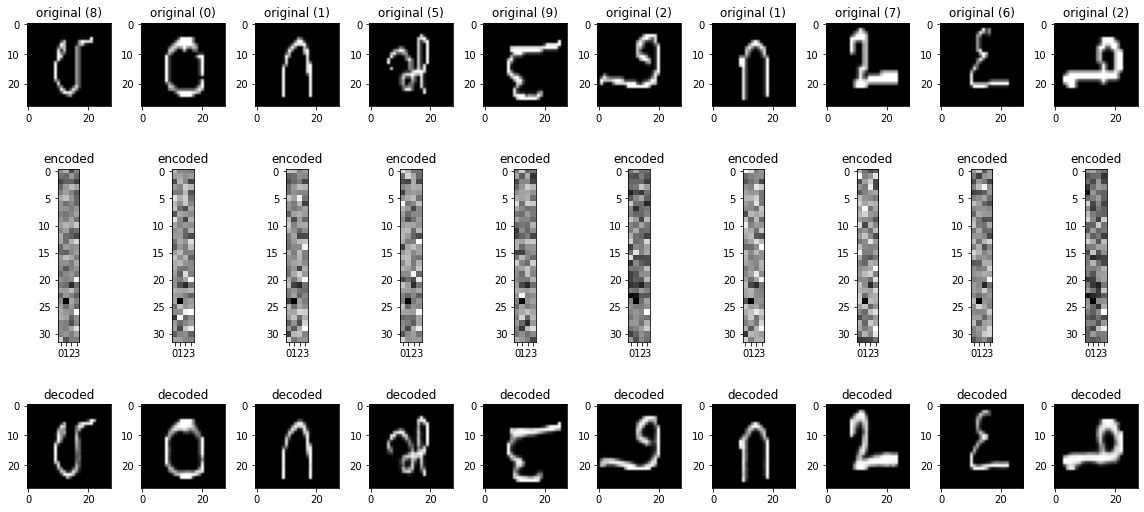

In [10]:
# visualize autoencoder output
nn = 10 # plot first nn samples in val set
encoded_imgs = encoder.predict(X_val)
decoded_imgs = ae.predict(X_val)
fig, axs = plt.subplots(3, nn, figsize=(16, 8))
for ii in range(nn):
    # original image
    axs[0,ii].imshow(X_val[ii].reshape((28, 28)), cmap='gray')
    axs[0,ii].set_title(f'original ({np.argmax(y_val[ii,])})')
    # encoded representation reshaped as 2D
    axs[1,ii].imshow(encoded_imgs[ii].reshape((32, -1)), cmap='gray')
    axs[1,ii].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[1,ii].set_title('encoded')
    # autoencoder output
    axs[2,ii].imshow(decoded_imgs[ii].reshape((28, 28)), cmap='gray')
    axs[2,ii].set_title('decoded')
fig.tight_layout()
plt.show()
fig.savefig('ae_output.pdf', format='pdf', bbox_inches='tight')

In [11]:
# classifier
encoder_output = tf.keras.layers.Input(shape=list(encoder.output.shape)[1:])
fc = tf.keras.layers.Flatten()(encoder_output)
fc = tf.keras.layers.Dense(256, activation='relu')(fc)
fc = tf.keras.layers.Dropout(0.5)(fc)
fc = tf.keras.layers.Dense(y_train.shape[1], activation='softmax')(fc)
clf = tf.keras.models.Model(inputs=encoder_output, outputs=fc, name='clf')
clf.summary()

Model: "clf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2, 2, 32)]        0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 35,594
Trainable params: 35,594
Non-trainable params: 0
_________________________________________________________________


In [12]:
# construct final model: encoder + classifier 
model = tf.keras.models.Model(inputs=input_img, outputs=clf(encoder(input_img)))
# set encoder as not trainable
model.layers[1].trainable = False
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 2, 2, 32)          391776    
_________________________________________________________________
clf (Functional)             (None, 10)                35594     
Total params: 427,370
Trainable params: 35,594
Non-trainable params: 391,776
_________________________________________________________________


In [13]:
# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                                 patience=5, verbose=1, min_lr=0)

checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, 
                                                save_best_only=True, save_weights_only = True)

# compile and fit
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=None, epochs=200,
          callbacks = [es, reduce_lr, checkpoint],
          validation_data=(X_val, y_val), verbose=2);

Epoch 1/200
1500/1500 - 6s - loss: 0.2002 - accuracy: 0.9524 - val_loss: 0.0646 - val_accuracy: 0.9808

Epoch 00001: val_loss improved from inf to 0.06456, saving model to model.h5
Epoch 2/200
1500/1500 - 5s - loss: 0.0686 - accuracy: 0.9796 - val_loss: 0.0431 - val_accuracy: 0.9868

Epoch 00002: val_loss improved from 0.06456 to 0.04306, saving model to model.h5
Epoch 3/200
1500/1500 - 5s - loss: 0.0520 - accuracy: 0.9841 - val_loss: 0.0359 - val_accuracy: 0.9897

Epoch 00003: val_loss improved from 0.04306 to 0.03586, saving model to model.h5
Epoch 4/200
1500/1500 - 5s - loss: 0.0432 - accuracy: 0.9870 - val_loss: 0.0305 - val_accuracy: 0.9902

Epoch 00004: val_loss improved from 0.03586 to 0.03049, saving model to model.h5
Epoch 5/200
1500/1500 - 5s - loss: 0.0380 - accuracy: 0.9878 - val_loss: 0.0288 - val_accuracy: 0.9910

Epoch 00005: val_loss improved from 0.03049 to 0.02884, saving model to model.h5
Epoch 6/200
1500/1500 - 5s - loss: 0.0331 - accuracy: 0.9895 - val_loss: 0.0253

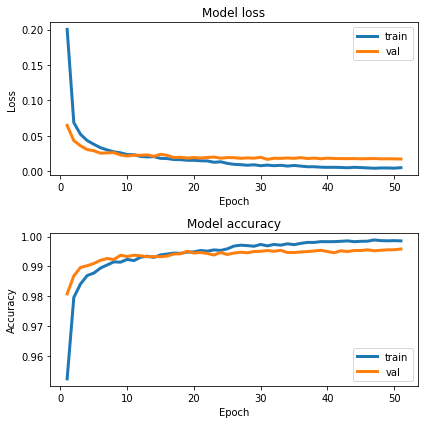

In [14]:
# plot history
df_plot = pd.DataFrame(model.history.history)
fig, axs = plt.subplots(2,1, figsize=(6,6))
axs[0].plot(df_plot.index+1, df_plot['loss'], lw=3, label='train')
axs[0].plot(df_plot.index+1, df_plot['val_loss'], lw=3, label='val')
axs[0].set(title='Model loss', ylabel='Loss')
axs[1].plot(df_plot.index+1, df_plot['accuracy'], lw=3, label='train')
axs[1].plot(df_plot.index+1, df_plot['val_accuracy'], lw=3, label='val')
axs[1].set(title='Model accuracy', ylabel='Accuracy')
for ax in axs:
  ax.set_xlabel('Epoch')
  ax.legend()
fig.tight_layout()
plt.show()
fig.savefig('model_hist.pdf', format='pdf', bbox_inches='tight')

In [15]:
# reload best weights and evaluate model
model.load_weights('model.h5')
model.evaluate(X_train, y_train)

1500/1500 [==============================] - 5s 3ms/step - loss: 0.0025 - accuracy: 0.9994


[0.002513512736186385, 0.9993749856948853]

In [16]:
# predict
y_pred = np.argmax(model.predict(X_test, batch_size=None, verbose=1),axis=1)
submission = sample_submission.copy()
submission['label'] = y_pred
submission.head()

157/157 [==============================] - 1s 2ms/step


,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7


In [17]:
submission.to_csv('submission.csv', index=False)
model.save('drive/MyDrive/mod9_ae2')

INFO:tensorflow:Assets written to: drive/MyDrive/mod9_ae2/assets
